# Machine Learning for CICY 3-Folds

We compute the Hodge numbers of CICY 3-folds using deep learning techniques inspired by the Inception architecture by Google.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time
import tarfile
import urllib
import json
import joblib
from nn_tools.utils.plotutils import *
from nn_tools.utils.datacreate import *
from nn_tools.nn_models.models import *
from nn_tools.nn_models.callbacks import *
from IPython.display import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
sns.set_theme()
ratio   = lambda x, y: (6 * y, 5 * x)

os.makedirs('./img', exist_ok=True)
os.makedirs('./models', exist_ok=True)

In [4]:
random_state = 123
np.random.seed(random_state)
tf.random.set_seed(random_state)

## Create a Saving Directory

Each model will be assigned to a different directory based on the time of running.

In [5]:
prefix  = 'inception_h21'
name    = time.strftime('%Y%m%d_%H%M%S', time.localtime())
mod_dir = os.path.join('./models', prefix + '_' + name)
img_dir = os.path.join('./img', prefix + '_' + name)

os.makedirs(mod_dir)
os.makedirs(img_dir)

In [6]:
print(f'Current working directory: {mod_dir}')

Current working directory: ./models/inception_h21_20201207_160407


## Load the Dataset

We then download the JSON file containing the configuration matrix and the Hodge numbers of the CICY.

In [7]:
os.makedirs('./data', exist_ok=True)

urllib.request.urlretrieve('http://www.lpthe.jussieu.fr/~erbin/files/data/cicy3o_data.tar.gz', './data/cicy3o_data.tar.gz')
with tarfile.open('./data/cicy3o_data.tar.gz', 'r') as tar:
    tar.extract('cicy3o.h5', path='./data')

In [8]:
df     = pd.read_hdf('./data/cicy3o.h5')
n_rows, n_cols = df.shape
print(f'Size of the dataset: {n_rows:d} rows, {n_cols:d} columns.')

Size of the dataset: 7890 rows, 31 columns.


We then select only the non product spaces:

In [9]:
df = df.loc[df['isprod'] == False]

We the pad the matrix to get the same size for all configuration matrices:

In [10]:
max_size = df['matrix'].apply(np.shape).max()

df.loc[:, 'matrix'] = df['matrix'].apply(lambda x: np.pad(x, ((0, max_size[0] - np.shape(x)[0]), (0, max_size[1] - np.shape(x)[1]))))
df = df[['h11', 'h21', 'matrix']]
n_rows, n_cols = df.shape

In [11]:
num_classes = [df['h11'].max() + 1, df['h21'].max() + 1]

We then split it into train, validation and test sets:

In [12]:
df_splits = {'train': 0.80, 'val_test': 0.5}
with open(os.path.join(mod_dir, 'train_ratio.json'), 'w') as f:
    json.dump(df_splits, f)

# training set
df_train = df.sample(frac=df_splits['train'], random_state=random_state)
df_oos   = df.loc[~df.index.isin(df_train.index)]

n_train = df_train.shape[0]

# validation/test
df_val   = df_oos.sample(frac=df_splits['val_test'], random_state=random_state)
df_test  = df_oos.loc[~df_oos.index.isin(df_val.index)]

n_val  = df_val.shape[0]
n_test = df_test.shape[0]

assert n_train + n_val + n_test == n_rows

In [13]:
del df, df_oos

## Outliers in the Training Set

We then study the outliers in the training set:

In [14]:
# remove outliers
df_train = df_train.loc[(df_train['h11'] >= 1) & (df_train['h11'] <= 16)
                        &
                        (df_train['h21'] >= 15) & (df_train['h21'] <= 86)
                       ]
n_train_pruned = df_train.shape[0]

In [15]:
print(f'Samples removed: {n_train - n_train_pruned:d} ({100 * (n_train - n_train_pruned) / n_train:.2f}% of the training set, {100 * (n_train - n_train_pruned) / n_rows:.2f}% of the total set)')

Samples removed: 12 (0.19% of the training set, 0.15% of the total set)


## Rescale the Matrices

We then rescale the matrices in the sets to improve the deep learning results:

In [16]:
# rescaling = {'min': df_train['matrix'].apply(lambda x: np.min(x)).min(),
#              'max': df_train['matrix'].apply(lambda x: np.max(x)).max()
#             }
rescaling = None

## Feature and Label Creation

We then create the features and the labels.

In [17]:
reshape = (12, 15, 1)

In [18]:
X_train = create_features(df_train['matrix'], rescaling=rescaling, reshape=reshape)
X_val   = create_features(df_val['matrix'], rescaling=rescaling, reshape=reshape)
X_test  = create_features(df_test['matrix'], rescaling=rescaling, reshape=reshape)

In [19]:
y_train = create_labels(df_train[['h21']], one_hot=True, num_classes=num_classes[1])
y_val   = create_labels(df_val[['h21']], one_hot=True, num_classes=num_classes[1])
y_test  = create_labels(df_test[['h21']], one_hot=True, num_classes=num_classes[1])

In [20]:
del df_train, df_val, df_test

## Inception Model

We then start to build the Inception model to be trained on the configuration matrices.

### Build the Model

In [21]:
model_data = {'input_shape':   reshape,
              'name':          'matrix',
              'learning_rate': 1.0e-3,
              'model':         'classification',
              'out_size':      102,
              'out_names':     ['h21'],
              'conv_1b1':      False,
              'conv_layers':   [32, 32, 32, 64, 64, 64, 32, 32, 32, 16],
              'conv_alpha':    0.0,
              'conv_class':    None,
              'conv_single':   False,
              'conv_red':      0,
              'feat_map':      0,
              'recurrent':     False,
              'fc_layers':     [],
              'fc_alpha':      0.0,
              'dropout':       0.5,
              'full_dropout':  0.1,
              'batchnorm':     0.99,
              'last_relu':     False,
              'loss_weights':  None,
              'l1_reg':        1.0e-3,
              'l2_reg':        1.0e-3,
              'output_layers': True,
              'random_state':  random_state
             }

with open(os.path.join(mod_dir, 'model_data.json'), 'w') as f:
    json.dump(model_data, f)

In [22]:
inception = nn_inception(**model_data)
inception.summary()

Model: "h21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
matrix (InputLayer)             [(None, 12, 15, 1)]  0                                            
__________________________________________________________________________________________________
matrix_convAa_0 (Conv2D)        (None, 12, 15, 32)   416         matrix[0][0]                     
__________________________________________________________________________________________________
matrix_convAb_0 (Conv2D)        (None, 12, 15, 32)   512         matrix[0][0]                     
__________________________________________________________________________________________________
matrix_actAa_0 (LeakyReLU)      (None, 12, 15, 32)   0           matrix_convAa_0[0][0]            
________________________________________________________________________________________________

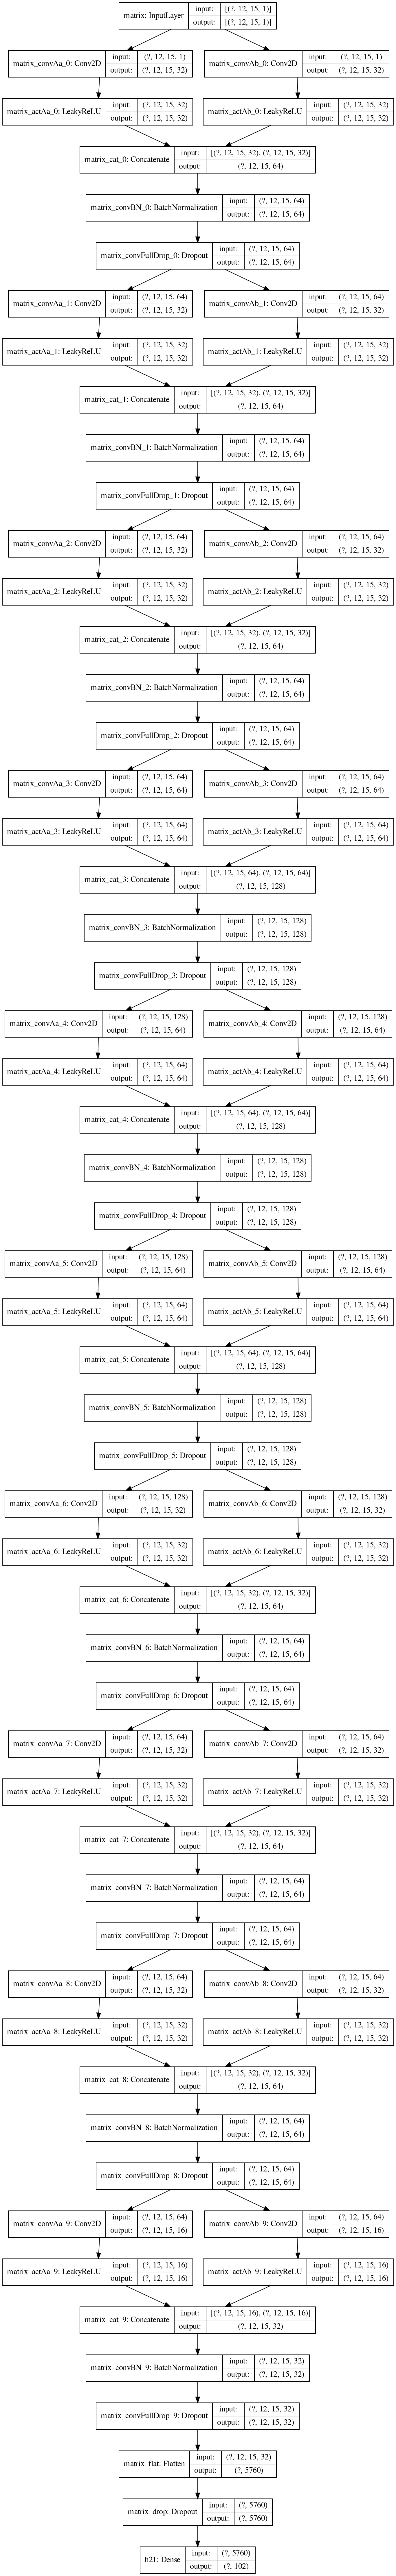

In [23]:
inception_graph = keras.utils.model_to_dot(inception, show_shapes=True, dpi=144)
inception_graph.write_pdf(os.path.join(img_dir, 'inception.pdf'))
Image(inception_graph.create_png(), width=480)

### Train the Model

In [24]:
fit_data = {'epochs':        5000,
            'batch_size':    32,
            'reduce_lr':     1500,
            'stat_interval': 100
           }

with open(os.path.join(mod_dir, 'fit_data.json'), 'w') as f:
    json.dump(fit_data, f)

In [25]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(mod_dir, 'inception_val_loss.h5'), monitor='val_loss', save_best_only=True),
             keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=fit_data['reduce_lr'], min_lr=1.0e-6),
             PrintCheckpoint(fit_data['stat_interval'])
            ]

inception_hst = inception.fit(x=X_train,
                              y=y_train,
                              batch_size=fit_data['batch_size'],
                              epochs=fit_data['epochs'],
                              verbose=0,
                              callbacks=callbacks,
                              validation_data=(X_val, y_val)
                             )

Training has started. Callouts will be printed every 100 epochs.

Training epoch 1. Started on 07/12/2020 at 16:04:10.

    Average epoch training time: 00 hours, 01 minutes, 01 seconds

    loss = 29.637592
    categorical_accuracy = 0.076568
    val_loss = 26.703423
    val_categorical_accuracy = 0.031766
    lr = 0.001000

Training epoch 100. Started on 07/12/2020 at 16:08:30.

    Average epoch training time: 00 hours, 00 minutes, 31 seconds

    loss = 2.011676
    categorical_accuracy = 0.488220
    val_loss = 2.203372
    val_categorical_accuracy = 0.447268
    lr = 0.001000

Training epoch 200. Started on 07/12/2020 at 16:11:49.

    Average epoch training time: 00 hours, 00 minutes, 21 seconds

    loss = 1.804913
    categorical_accuracy = 0.583890
    val_loss = 2.358991
    val_categorical_accuracy = 0.459975
    lr = 0.001000

Training epoch 300. Started on 07/12/2020 at 16:15:08.

    Average epoch training time: 00 hours, 00 minutes, 16 seconds

    loss = 1.725202
    c

## Visualisation of the Training Data

We plot the metrics and the loss of the training for reference.

In [26]:
inception_hst = pd.DataFrame(inception_hst.history)

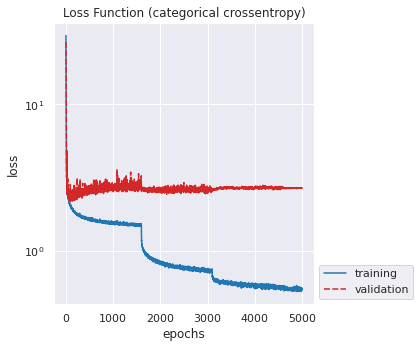

In [27]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.lineplot(data=inception_hst[['loss', 'val_loss']],
             palette=['tab:blue', 'tab:red'],
             ax=ax
            )
ax.set(title='Loss Function (categorical crossentropy)',
       xlabel='epochs',
       ylabel='loss',
       yscale='log'
      )
ax.legend(['training', 'validation'], bbox_to_anchor=(1.0, 0.0), loc='lower left')

savefig('inception_loss', fig, root=img_dir, show=True)

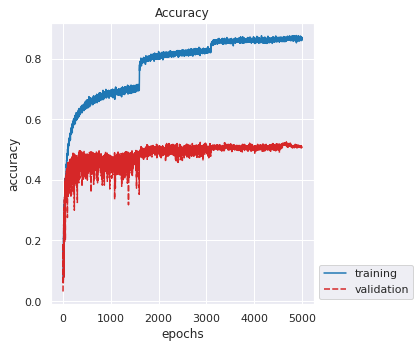

In [28]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.lineplot(data=inception_hst[['categorical_accuracy', 'val_categorical_accuracy']],
             palette=['tab:blue', 'tab:red'],
             ax=ax
            )
ax.set(title='Accuracy',
       xlabel='epochs',
       ylabel='accuracy'
      )
ax.legend(['training', 'validation'], bbox_to_anchor=(1.0, 0.0), loc='lower left')

savefig('inception_accuracy', fig, root=img_dir, show=True)

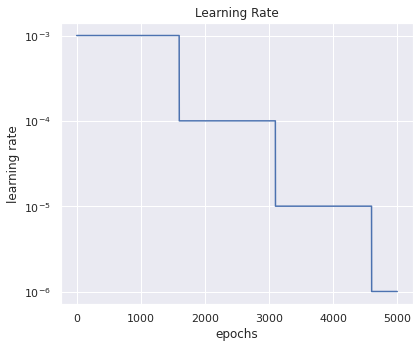

In [29]:
fig, ax = plt.subplots(1, 1, figsize=ratio(1,1))

sns.lineplot(data=inception_hst['lr'],
             ax=ax
            )
ax.set(title='Learning Rate',
       xlabel='epochs',
       ylabel='learning rate',
       yscale='log'
      )

savefig('inception_lr', fig, root=img_dir, show=True)

## Test Predictions

We finally compute the predictions on the test set.

In [39]:
y_pred = inception.predict(X_test)
y_pred = {key: value.argmax(axis=1) for key, value in y_pred.items()}
y_true = {key: value.argmax(axis=1) for key, value in y_test.items()}

In [43]:
test_accuracy = {key: np.mean(np.equal(y_pred[key], y_true[key])) for key in y_true.keys()}
for key in test_accuracy.keys():
    print(f'Test set accuracy: {test_accuracy[key]:.3f}')

Test set accuracy: 0.504
